# **CNNs and finetuning**

. Download the CIFAR 10 dataset (original data can be found here, and here is a link to the pickled python version.

. Use the pretrained Resnet18 model (from trochvision) to extract features. Use the features as inputs in a new multi-class logistic regression model (use nn.Linear/ nn.Module to define your model) -(a) Describe any choices made and report test performance. -(b) Display the top 5 correct predictions and the top 5 incorrect predictions in each class (show the images and the prediction labels) compactly.

. Finetune the Resnet18 model's parameters suitably and repeat parts (a) and (b) from above. Compare the performance of finetuning versus using extracted features.

In [32]:
# Importing packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader, Dataset
import matplotlib.pyplot as plt
import time
import os
import copy

downloading datasets and converting them into suitable format by configuring transformation parameters 

In [11]:
# Configuring transformation parameters to form dataframes in suitable format.
normalization_parameters = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

# train configuration
train_config = transforms.Compose([
    transforms.RandomCrop(32, padding = 4, padding_mode = 'reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*normalization_parameters, inplace=True)
])

# test configuration
test_config = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*normalization_parameters, inplace=True)
])

# using additional processing if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# downloading and dataset in .gz and creating train and reading them using transormation parameters 
dataset = torchvision.datasets.CIFAR10(root = "data/", download=True, transform = train_config)
test_data = torchvision.datasets.CIFAR10(root = "data/", download = True, train = False, transform = test_config)

Files already downloaded and verified
Files already downloaded and verified


Splitting dataset into train, validation and test

In [12]:
# defining the split between train and validation
split_ratio = 0.2

#computing training and validation indexes
train_index, validation_index = random_split(dataset, [int((1-split_ratio) * len(dataset)), int(split_ratio * len(dataset))])
size=32
train = DataLoader(train_index, size, shuffle = True, pin_memory = True)
validation = DataLoader(validation_index, size, shuffle = True, pin_memory= True)
test = DataLoader(test_data, size, shuffle = True, pin_memory= True)

class_names = dataset.classes
training_data = {'train':train, 'validation':validation}
dataset_sizes = {'train':int(len(dataset)*(1-split_ratio)), 'validation':int(len(dataset)*split_ratio)}

Viewing the training dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


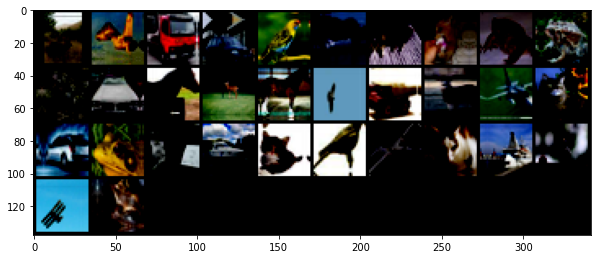

In [13]:
# Function to plot images collectively
def image_plot(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (10, 10))
        ax.imshow(make_grid(images, 10).permute(1,2,0))
        break
image_plot(train)

Defining functions to train and visualize the data

In [14]:
# Function to train model using criterion, optimizer, scheduler and epochs = 25
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Every epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in training_data[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [45]:
# function to visualize the model
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(training_data['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
# function to visualize items in a model
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

Configuring model parameters using pretrained features

In [16]:
# using pretrained model features
pretrained_ft = models.resnet18(pretrained=True)
num_ftrs = pretrained_ft.fc.in_features
pretrained_ft.fc = nn.Linear(num_ftrs, 10)
pretrained_ft = pretrained_ft.to(device)

# Using cross entropy as the criterion
criterion = nn.CrossEntropyLoss()

# optimizing parameters using optimizer by passing learning rate and momentum
optimizer_ft = optim.SGD(pretrained_ft.parameters(), lr=0.001, momentum=0.9)

# reducing learning rate by 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Building a model using pretrained model features, entropy, optimizer, scheduler and 25 epochs

In [17]:
#Training the model
model_ft = train_model(pretrained_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1493 Acc: 0.6021
validation Loss: 0.8346 Acc: 0.7110

Epoch 1/24
----------
train Loss: 0.8228 Acc: 0.7197
validation Loss: 0.7190 Acc: 0.7475

Epoch 2/24
----------
train Loss: 0.7153 Acc: 0.7532
validation Loss: 0.6662 Acc: 0.7651

Epoch 3/24
----------
train Loss: 0.6564 Acc: 0.7720
validation Loss: 0.6084 Acc: 0.7891

Epoch 4/24
----------
train Loss: 0.6103 Acc: 0.7888
validation Loss: 0.6012 Acc: 0.7948

Epoch 5/24
----------
train Loss: 0.5688 Acc: 0.8020
validation Loss: 0.5783 Acc: 0.8026

Epoch 6/24
----------
train Loss: 0.5463 Acc: 0.8100
validation Loss: 0.5591 Acc: 0.8097

Epoch 7/24
----------
train Loss: 0.4619 Acc: 0.8394
validation Loss: 0.5184 Acc: 0.8250

Epoch 8/24
----------
train Loss: 0.4413 Acc: 0.8454
validation Loss: 0.5111 Acc: 0.8210

Epoch 9/24
----------
train Loss: 0.4296 Acc: 0.8506
validation Loss: 0.5030 Acc: 0.8269

Epoch 10/24
----------
train Loss: 0.4232 Acc: 0.8489
validation Loss: 0.5080 Acc: 0.8263

Epoch 11/

Viewing and visualizing the predictions made by the model 

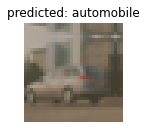

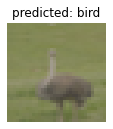

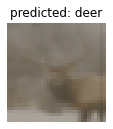

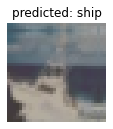

In [46]:
visualize_model(model_ft)

Building a fine tuned model

In [48]:
# configuring the fine tuned model
model_tuned = torchvision.models.resnet18(pretrained=True)
for param in model_tuned.parameters():
    param.requires_grad = False

num_ftrs = model_tuned.fc.in_features
model_tuned.fc = nn.Linear(num_ftrs, 10)

model_tuned = model_tuned.to(device)

# criterion is still cross entropy
criterion = nn.CrossEntropyLoss()

# only parameters of final layer are being optimized 
optimizer_conv = optim.SGD(model_tuned.fc.parameters(), lr=0.001, momentum=0.9)

# scheduler same as above 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Building the model

In [49]:
# Training the fine tuned model
model_tuned = train_model(model_tuned, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.7920 Acc: 0.3698
validation Loss: 1.6679 Acc: 0.4262

Epoch 1/24
----------
train Loss: 1.6770 Acc: 0.4118
validation Loss: 1.6417 Acc: 0.4328

Epoch 2/24
----------
train Loss: 1.6612 Acc: 0.4163
validation Loss: 1.6519 Acc: 0.4284

Epoch 3/24
----------
train Loss: 1.6525 Acc: 0.4217
validation Loss: 1.6326 Acc: 0.4406

Epoch 4/24
----------
train Loss: 1.6529 Acc: 0.4201
validation Loss: 1.6369 Acc: 0.4291

Epoch 5/24
----------
train Loss: 1.6448 Acc: 0.4252
validation Loss: 1.6155 Acc: 0.4466

Epoch 6/24
----------
train Loss: 1.6402 Acc: 0.4226
validation Loss: 1.6281 Acc: 0.4396

Epoch 7/24
----------
train Loss: 1.6051 Acc: 0.4404
validation Loss: 1.6143 Acc: 0.4484

Epoch 8/24
----------
train Loss: 1.5989 Acc: 0.4391
validation Loss: 1.5868 Acc: 0.4589

Epoch 9/24
----------
train Loss: 1.5942 Acc: 0.4438
validation Loss: 1.5951 Acc: 0.4512

Epoch 10/24
----------
train Loss: 1.5903 Acc: 0.4450
validation Loss: 1.5885 Acc: 0.4574

Epoch 11/

Viewing and visualizing the predictions made by the tuned model 

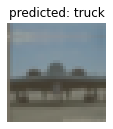

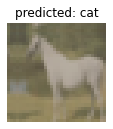

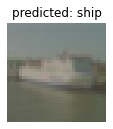

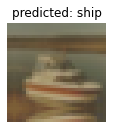

In [50]:
visualize_model(model_tuned)

On comparing the model built with predifined features and the model built with fine tuned features, we observe that the model with the predifined features minimized validation loss to a greater extent with a higher validation accuracy. However it took almost four times the time it took to train the one with fine tuned features. This indicates a tradeoff between loss minimized, accuracy and the training time.